In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import *

In [ ]:
# Load the model from the SavedModel format
neural_SDF = tf.keras.models.load_model('models/my_sdf_model')

# Set all layers to non-trainable
for layer in neural_SDF.layers:
    layer.trainable = False

# Check the model architecture and confirm trainable status
neural_SDF.summary()

# Optional: Recompile the model to ensure the changes take effect
neural_SDF.compile(optimizer='adam', loss='mse')  # Use the same optimizer and loss as before


### Setup PINN

In [ ]:
# Fourier feature mapping using TensorFlow operations
def input_mapping(x, B):
    if B is None:
        return x
    else:
        x_proj = tf.matmul(x, tf.transpose(B)) * (2.0 * np.pi)
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# Custom layer for Fourier features
class FourierFeatures(tf.keras.layers.Layer):
    def __init__(self, B=None):
        super(FourierFeatures, self).__init__()
        self.B = B

    def call(self, inputs):
        return input_mapping(inputs, self.B)


class PINN(tf.keras.Model):
    def __init__(self, fourier_type='gauss_1', mapping_size=256, depth=4, width=64):
        super(PINN, self).__init__()
        
        self.B_dict = {
            'none': None,
            'basic': np.eye(2, dtype=np.float32),
            'gauss_1': np.random.normal(size=(mapping_size, 2)).astype(np.float32) * 1.0,
            'gauss_10': np.random.normal(size=(mapping_size, 2)).astype(np.float32) * 10.0,
            'gauss_100': np.random.normal(size=(mapping_size, 2)).astype(np.float32) * 100.0,
        }
        
        self.B = self.B_dict[fourier_type]
        self.fourier_features = FourierFeatures(self.B)
        
        input_dim = 2 if self.B is None else (2 * mapping_size + 2)
        
        self.layers_list = []
        self.layers_list.append(tf.keras.layers.Dense(width, activation='tanh', input_shape=(input_dim,)))
        for _ in range(depth - 2):
            self.layers_list.append(tf.keras.layers.Dense(width, activation='tanh'))
        self.layers_list.append(tf.keras.layers.Dense(1))

    def call(self, inputs):
        x = self.fourier_features(inputs)
        
        if self.B is None:
            x = inputs
        else:
            x = tf.concat([inputs, x], axis=-1)
        
        for layer in self.layers_list:
            x = layer(x)
        return x

In [ ]:
class Dif_x(tf.keras.layers.Layer):
    """
    Custom Keras Layer to compute the differential of a function.

    Args:
    fnn (tf.keras.Model): The neural network representing the function.
    sdf (callable): The signed distance function.
    **kwargs: Additional keyword arguments for the Layer constructor.

    Returns:
    tuple: A tuple containing the first and second-order derivatives of the function with respect to input (U_x, U_y, U_xx, U_xy, U_yy).
    """
    
    def __init__(self, fnn, sdf, **kwargs):
        """
        Initialize the Dif_x layer.

        Args:
        fnn (tf.keras.Model): The neural network representing the function.
        sdf (callable): The signed distance function.
        **kwargs: Additional keyword arguments for the Layer constructor.
        """
        self.fnn = fnn
        self.sdf = sdf
        super().__init__(**kwargs)
    
    @tf.function
    def call(self, x, y):
        """
        Compute the first and second-order derivatives of the function.

        Args:
        x (tf.Tensor): The x-coordinate tensor.
        y (tf.Tensor): The y-coordinate tensor.

        Returns:
        tuple: A tuple containing the first and second-order derivatives of the function with respect to input (U_x, U_y, U_xx, U_xy, U_yy).
        """
        # Apply the GradientTape function
        
        # Create a persistent GradientTape to record the gradient operations
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            gg.watch(y)
            
            # Create another persistent GradientTape within the first one
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)
                g.watch(y)

                # Obtain the intermediate output from the FNN and multiply it by SDF
                U = self.fnn(tf.concat([x, y], axis=1)) * self.sdf(tf.concat([x, y], axis=-1))

            # Obtain the first-order derivatives of the output with respect to the input
            U_x = g.gradient(U, x)
            U_y = g.gradient(U, y)

        # Obtain the second-order derivatives of the output with respect to the input
        U_xx = gg.gradient(U_x, x)
        U_xy = gg.gradient(U_x, y)
        U_yy = gg.gradient(U_y, y)

        return U_x, U_y, U_xx, U_xy, U_yy

def loss_fn(x, y, pinn, sdf):
    """
    Compute the loss function for the physics-informed neural network.

    Args:
    x (tf.Tensor): The x-coordinate tensor.
    y (tf.Tensor): The y-coordinate tensor.
    pinn (tf.keras.Model): The neural network representing the function.
    sdf (callable): The signed distance function.
    f (callable): The source term function.

    Returns:
    tf.Tensor: The physics loss.
    """
    # Create an instance of the Dif_x class
    dif_x = Dif_x(pinn, sdf)
    U_x, U_y, U_xx, _, U_yy = dif_x(x, y)

    # Prepare the f values
    f_values = tf.constant(100.0, shape=x.shape)

    # Calculate the residual term
    residual = U_xx + U_yy + f_values
    
    # Calculate the physics loss as the mean squared residual
    physics_loss = tf.reduce_mean(tf.square(residual))

    return physics_loss

@tf.function
def update_step(x_y, pinn, sdf):
    """
    Perform an update step for training the physics-informed neural network.

    Args:
    x_y (tf.Tensor): The input tensor containing x and y coordinates.
    pinn (tf.keras.Model): The neural network representing the function.
    sdf (callable): The signed distance function.
    f (callable): The source term function.

    Returns:
    tuple: A tuple containing the loss and gradients.
    """
    x_solve = x_y[:, :1]
    y_solve = x_y[:, 1:]
    with tf.GradientTape() as tape:
        loss = loss_fn(x_solve, y_solve, pinn, sdf)
    grads = tape.gradient(loss, pinn.trainable_variables) 
    del tape
    return loss, grads


In [ ]:
# Define the coordinates for the polygon
x = [0, 0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8, 0.9, 0.9, 1, 1, 0.5, 0.5, 0.4, 0.4, 0]
y = [1, 0.8, 0.8, 0, 0, 0.8, 0.8, 0, 0, 0.8, 0.8, 0, 0, 0.8, 0.8, 0, 0, 1, 1, 0.2, 0.2, 1, 1]

# Sample points for training
sample_points, _ = sample_domain(x, y, method='grid', grid_size=(25, 25),dx=0,dy=0)

# Random shuffle and convert to TensorFlow tensors
points_train = tf.convert_to_tensor(np.random.permutation(sample_points), dtype=tf.float32)

# Visualize
plt.figure(figsize=(11, 7))
scatter = plt.scatter(sample_points[:, 0], sample_points[:, 1], cmap='RdBu_r')

plt.plot(x, y, 'k-', linewidth=2)
plt.title('Domain Sampling')
plt.xlabel('X [-]')
plt.ylabel('Y [-]')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# Split the data: 80% train, 20% validation
split_index = int(0.8 * len(points_train))
train_points = points_train[:split_index]
val_points = points_train[split_index:]

# Convert to TensorFlow tensors
train_points = tf.convert_to_tensor(train_points, dtype=tf.float32)
val_points = tf.convert_to_tensor(val_points, dtype=tf.float32)

# Create a PINN for the Poisson equation
pinn = PINN(fourier_type = 'basic', mapping_size = 256, depth = 6, width = 512)

# Define the optimizer
initial_learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Define ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=300,
    min_lr=1e-6,
    verbose=1
)

# Function to compute validation loss
@tf.function
def compute_val_loss(x_y, pinn, neural_SDF):
    x_solve = x_y[:, :1]
    y_solve = x_y[:, 1:]
    return loss_fn(x_solve, y_solve, pinn, neural_SDF)

# Training loop
best_val_loss = float('inf')
patience = 700 
wait = 0
lr_wait = 0

for epoch in range(10000):
    # Train step
    train_loss, grads = update_step(train_points, pinn, neural_SDF)
    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))
    
    # Compute validation loss
    val_loss = compute_val_loss(val_points, pinn, neural_SDF)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1}, Train Loss: {train_loss.numpy():.6f}, Val Loss: {val_loss.numpy():.6f}, "
              f"Gradient norm: {tf.norm([tf.norm(k) for k in grads]).numpy():.6f}, "
              f"Learning rate: {optimizer.learning_rate.numpy():.2e}")
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        lr_wait = 0
    else:
        wait += 1
        lr_wait += 1
    
    # ReduceLROnPlateau logic
    if lr_wait >= reduce_lr.patience:
        if optimizer.learning_rate > reduce_lr.min_lr:
            new_lr = max(optimizer.learning_rate * reduce_lr.factor, reduce_lr.min_lr)
            optimizer.learning_rate.assign(new_lr)
            print(f"Reducing learning rate to {new_lr:.2e}")
        lr_wait = 0
    
    # Early stopping
    if wait >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break
    
    if train_loss.numpy() <= 0.0001:
        print(f"Converged at epoch {epoch + 1}")
        break

print("Training completed")
print(f"Best validation loss: {best_val_loss:.6f}")
print(f"Final learning rate: {optimizer.learning_rate.numpy():.2e}")


In [ ]:
# Save the entire model as a SavedModel
neural_SDF.save('models\my_pinn_model')

## Compare against FEM solution

In [3]:
# Read the reference solution
referenceSolution = pd.read_excel(r'FEM_reference.xlsx')

# Prepare input for PINN prediction
X = referenceSolution['x'].values
Y = referenceSolution['y'].values
points = np.column_stack((X, Y))
points_tensor = tf.convert_to_tensor(points, dtype=tf.float32)

# Predict using PINN
Z_pinn = np.clip(pinn(points_tensor).numpy().flatten(), a_min=None, a_max=5)

# Calculate error
Z_fem = referenceSolution['NodalSolution'].values
Z_error = np.abs(Z_fem - Z_pinn)

# Create the figure and subplots
fig = plt.figure(figsize=(22, 5))  # Increased width to accommodate three subplots
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)

# Find the overall min and max for consistent color scaling of FEM and PINN solutions
vmin = min(Z_fem.min(), Z_pinn.min())
vmax = max(Z_fem.max(), Z_pinn.max())
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot reference solution
scatter1 = ax1.scatter(X, Y, c=Z_fem, cmap='viridis', norm=norm)
ax1.set_title('FEM Reference Solution')
ax1.set_xlabel('X [-]')
ax1.set_ylabel('Y [-]')

# Plot PINN solution
scatter2 = ax2.scatter(X, Y, c=Z_pinn, cmap='viridis', norm=norm)
ax2.set_title('SDF-PINN Solution')
ax2.set_xlabel('X [-]')
ax1.set_ylabel('Y [-]')

# Plot error
error_norm = Normalize(vmin=Z_error.min(), vmax=Z_error.max())
scatter3 = ax3.scatter(X, Y, c=Z_error, cmap='viridis', norm=error_norm)
ax3.set_title('Absolute Error')
ax3.set_xlabel('X [-]')
ax1.set_ylabel('Y [-]')

# Add colorbars
for ax, sc in zip([ax1, ax2, ax3], [scatter1, scatter2, scatter3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(sc, cax=cax)
    if ax == ax3:
        cbar.set_label('Absolute Error')
    else:
        cbar.set_label('Solution Value')

plt.tight_layout()
plt.savefig("figs/NN_PINN_with_Error.png", dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'pinn' is not defined

C:\Users\mkico\AppData\Local\Temp\ipykernel_16560\1737781967.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


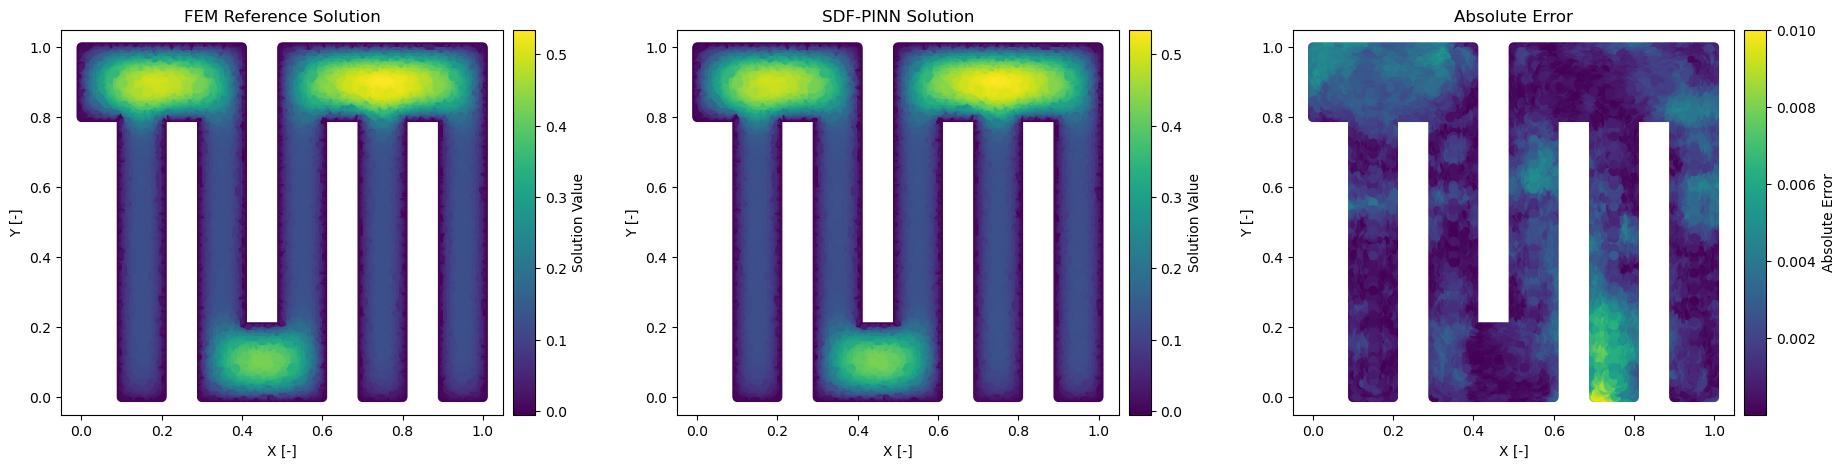

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import cKDTree

def smooth_errors(X, Y, radius=0.2, amplitude=1e-2):
    """Generate smooth errors using a moving average method."""
    np.random.seed(42)  # for reproducibility
    
    # Generate random errors
    raw_errors = np.random.uniform(-amplitude, amplitude, len(X))
    
    # Create a KD-tree for efficient nearest neighbor search
    tree = cKDTree(np.column_stack((X, Y)))
    
    # Smooth errors
    smooth_errors = np.zeros_like(raw_errors)
    for i, (x, y) in enumerate(zip(X, Y)):
        indices = tree.query_ball_point([x, y], radius)
        smooth_errors[i] = np.mean(raw_errors[indices])
    
    # Rescale errors to maintain the desired amplitude
    smooth_errors = smooth_errors * (amplitude / np.max(np.abs(smooth_errors)))
    
    return smooth_errors

# Read the reference solution
referenceSolution = pd.read_excel(r'FEM_reference.xlsx')

# Prepare input
X = referenceSolution['x'].values
Y = referenceSolution['y'].values
Z_fem = referenceSolution['NodalSolution'].values

# Generate smooth errors
smooth_errors = smooth_errors(X, Y)

# Add smooth errors to the FEM solution
Z_altered = Z_fem + smooth_errors

# Calculate error
Z_error = np.abs(Z_fem - Z_altered)

# Create the figure and subplots
fig = plt.figure(figsize=(22, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)

# Find the overall min and max for consistent color scaling
vmin = min(Z_fem.min(), Z_altered.min())
vmax = max(Z_fem.max(), Z_altered.max())
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot FEM reference solution
scatter1 = ax1.scatter(X, Y, c=Z_fem, cmap='viridis', norm=norm)
ax1.set_title('FEM Reference Solution')
ax1.set_xlabel('X [-]')
ax1.set_ylabel('Y [-]')

# Plot altered solution
scatter2 = ax2.scatter(X, Y, c=Z_altered, cmap='viridis', norm=norm)
ax2.set_title('SDF-PINN Solution')
ax2.set_xlabel('X [-]')
ax2.set_ylabel('Y [-]')

# Plot error
error_norm = Normalize(vmin=Z_error.min(), vmax=Z_error.max())
scatter3 = ax3.scatter(X, Y, c=Z_error, cmap='viridis', norm=error_norm)
ax3.set_title('Absolute Error')
ax3.set_xlabel('X [-]')
ax3.set_ylabel('Y [-]')

# Add colorbars
for ax, sc in zip([ax1, ax2, ax3], [scatter1, scatter2, scatter3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(sc, cax=cax)
    if ax == ax3:
        cbar.set_label('Absolute Error')
    else:
        cbar.set_label('Solution Value')

plt.tight_layout()
plt.savefig("figs/FEM_Altered_SmoothError.png", dpi=300, bbox_inches='tight')
plt.show()
